In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from typing import List
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf
from scipy.stats import linregress
from collections import defaultdict
from pathlib import Path

plt.rcParams["figure.figsize"] = (20, 12)
plt.rcParams["font.size"] = 22
np.random.seed(42)

ECL_PATH = Path(
    "/Users/eiriksteen/Personal/research/virginia/code/Time-Series-Library/dataset/electricity")
ETT_PATH = Path(
    "/Users/eiriksteen/Personal/research/virginia/code/Time-Series-Library/dataset/ETT-small")
WEATHER_PATH = Path(
    "/Users/eiriksteen/Personal/research/virginia/code/Time-Series-Library/dataset/weather")

<h2> Electricity </h2>

<h3> Let's start with basic visualization, missing value analysis, and IQR anomaly detection </h3>

In [257]:
ecl_df = pd.read_csv(ECL_PATH / "electricity.csv")
ecl_df["date"] = pd.to_datetime(ecl_df["date"])
ecl_df.set_index("date", inplace=True)
ecl_df.sort_index(inplace=True)
ecl_df.head()

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,OT
date,,,,,,,,,,,,,,,,,,,,,
2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


In [258]:
ecl_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,OT
count,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,...,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000
mean,23.263762,112.885569,16.821624,440.335196,200.536724,755.035166,25.943659,1022.549270,214.867321,227.069267,...,2072.031592,1165.538853,200529.124848,10065.918491,15678.371236,350.702137,51.490344,2264.188641,507.008858,3335.883744
std,24.127164,25.553141,49.190377,152.601050,69.727348,249.598861,27.392344,231.480251,83.792517,102.182571,...,1211.430647,736.035668,146054.610575,6568.697998,9738.020500,241.241444,37.228837,545.279372,267.445473,552.754335
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,95.000000,8.000000,334.750000,148.000000,572.000000,13.000000,840.000000,157.000000,149.000000,...,850.000000,452.000000,69300.000000,3639.000000,6456.000000,94.000000,27.000000,1999.000000,233.000000,2920.000000
50%,11.000000,113.000000,8.000000,400.000000,190.000000,725.000000,16.000000,1015.000000,194.000000,204.000000,...,1962.500000,1278.000000,174000.000000,9361.000000,13866.000000,361.000000,37.000000,2319.000000,504.000000,3271.000000
75%,24.000000,130.000000,10.000000,511.000000,239.000000,881.000000,24.000000,1169.000000,253.000000,283.000000,...,3019.000000,1726.000000,267725.000000,14719.250000,24706.000000,505.000000,57.000000,2607.000000,704.000000,3632.000000
max,140.000000,296.000000,601.000000,1170.000000,547.000000,1984.000000,178.000000,2102.000000,600.000000,752.000000,...,5749.000000,3340.000000,764000.000000,28572.000000,39728.000000,1330.000000,205.000000,4449.000000,1369.000000,6035.000000


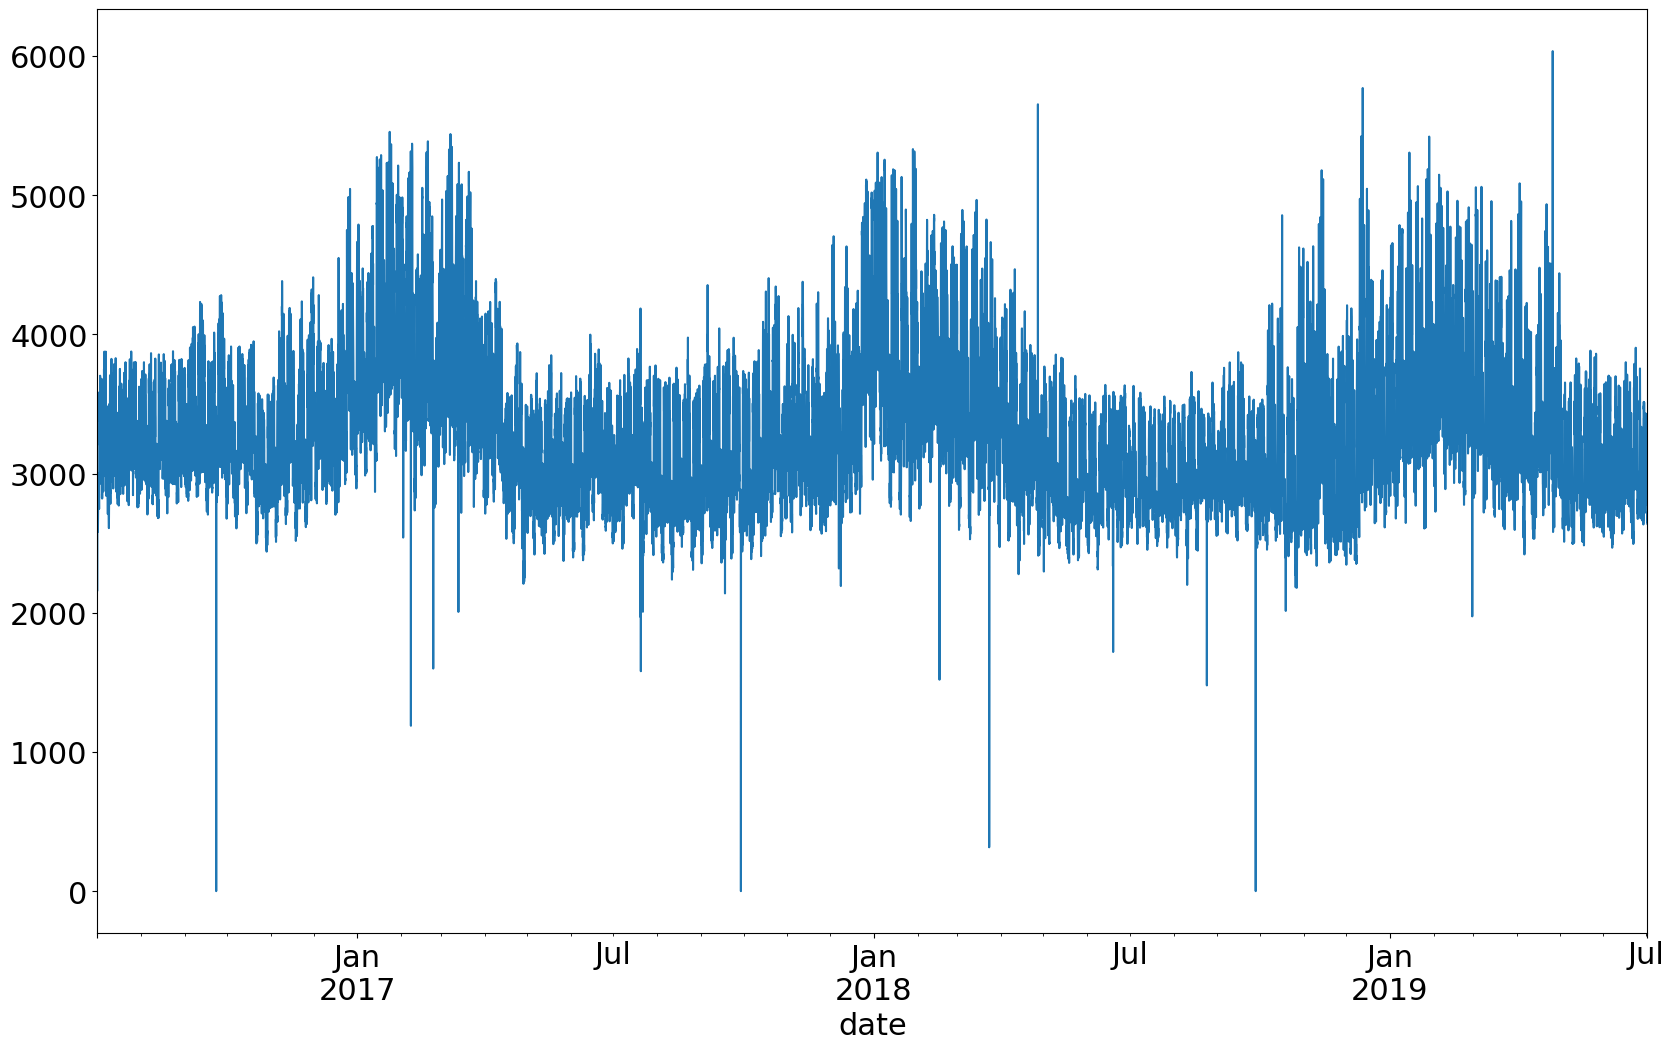

In [259]:
ecl_df.T.loc["OT"].plot();

<h3> We can already see that it is stationary, which means that the series is not expected to be too challenging to forecast. Strong seasonality as expected with electricity consumption data. </h3>

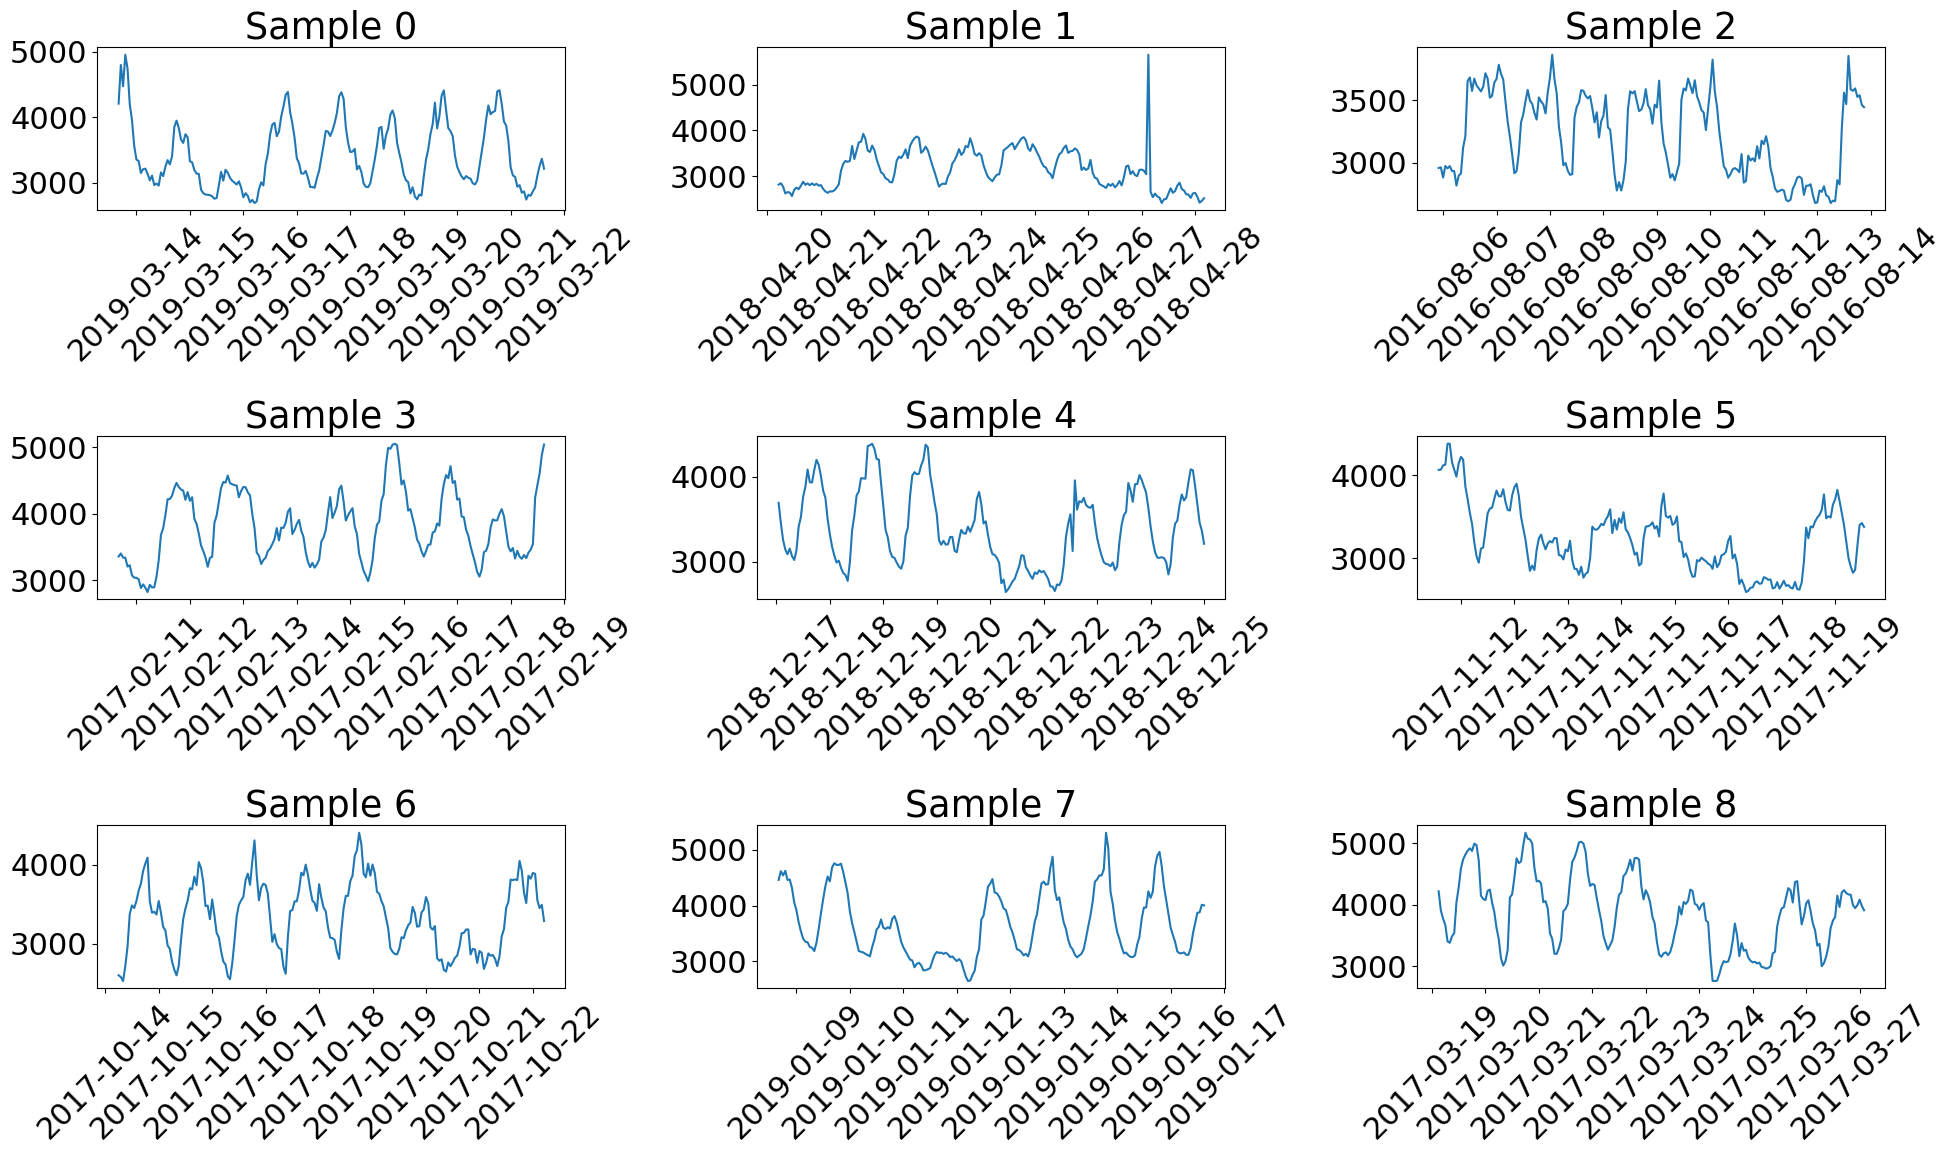

In [260]:
def plot_samples(df: pd.DataFrame, n_row = 3, n_col = 3, target="OT", seq_len=96*2) -> None:
    """
    Plot random samples from the DataFrame.
    """

    target_series = df.T.loc[target]
    fig, axs = plt.subplots(n_row, n_col)
    for i in range(n_row):
        for j in range(n_col):
            rand_start = np.random.randint(0, len(target_series) - seq_len)
            # set x datetime values 45 degrees
            axs[i, j].xaxis.set_tick_params(rotation=45)
            axs[i, j].plot(target_series[rand_start:rand_start+seq_len])
            axs[i, j].set_title(f"Sample {i*n_col + j}")
    plt.tight_layout()
    plt.show()

plot_samples(ecl_df)

In [261]:
def missing_value_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate a formatted string summarizing missing values for each column in a DataFrame.
    """
    missing_counts = df.isnull().sum()
    total_rows = len(df)

    missing_df = pd.DataFrame({
        'Column': missing_counts.index,
        'Missing_Count': missing_counts.values,
        'Missing_Percentage': (missing_counts.values / total_rows * 100).round(2)
    })

    missing_df = missing_df[missing_df['Missing_Count']
                            > 0].sort_values('Missing_Count', ascending=False)

    return missing_df


In [262]:
# Test the improved missing_value_summary function
missing_value_summary(ecl_df)

,Column,Missing_Count,Missing_Percentage


<h3> No missing values </h3>

In [ ]:
def iqr_anomaly_detect(df: pd.DataFrame) -> pd.DataFrame:
    """
    Detect anomalies in a DataFrame using the IQR method.
    """

    # Calculate IQR for each column
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Identify outliers
    outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

    # Calculate fraction per column
    outlier_fraction = outliers.sum(axis=0) / len(df)

    # Sort by fraction of outliers
    outlier_fraction = outlier_fraction.sort_values(ascending=False)

    return outliers, outlier_fraction

ecl_outliers, ecl_iqr_anomalies = iqr_anomaly_detect(ecl_df)
ecl_iqr_anomalies.head(20)

182    0.242891
0      0.210348
83     0.189819
2      0.161420
317    0.140473
113    0.135797
84     0.130627
6      0.125684
59     0.094358
22     0.069115
303    0.061169
66     0.060447
44     0.054592
318    0.053756
245    0.052844
307    0.052616
79     0.052578
96     0.052540
12     0.049650
310    0.049308
dtype: float64

In [264]:
ecl_iqr_anomalies.loc["OT"]

0.024597019464720194

<h3> Top 10 most anomalous columns have quite high rates with 5-25%. Could be further explored. However, as almost all SOTA forecasters use channel independence, including the ones we use as baselines, anomalies in columns aside from the prediction target won't affect performance. The rate of 2.5% in the target column is acceptably low. </h3>

<h3> Let's now explore how the distribution in the series changes over time. This can support our hypothesis that input characteristics vary to the extent that different models will be optimal for different sections of the input. We start with an ADF test. We then compute time series showing how the following metrics change over time for the slices:

* Mean
* STD
* Autocorrelation (mean)
* Trend (slope of fitted linear curve)
* Sample-skewness
* Sample-kurtosis

These metrics should give a reasonably complete picture regarding how patterns in the series change over time. 

 </h3>

In [265]:
def adf_test(df: pd.DataFrame, target: str = "OT") -> None:
    """
    Perform Augmented Dickey-Fuller test on a time series.
    """
    result = adfuller(df.T.loc[target])
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")

adf_test(ecl_df)

ADF Statistic: -14.05363384111425
p-value: 3.145309581380042e-26


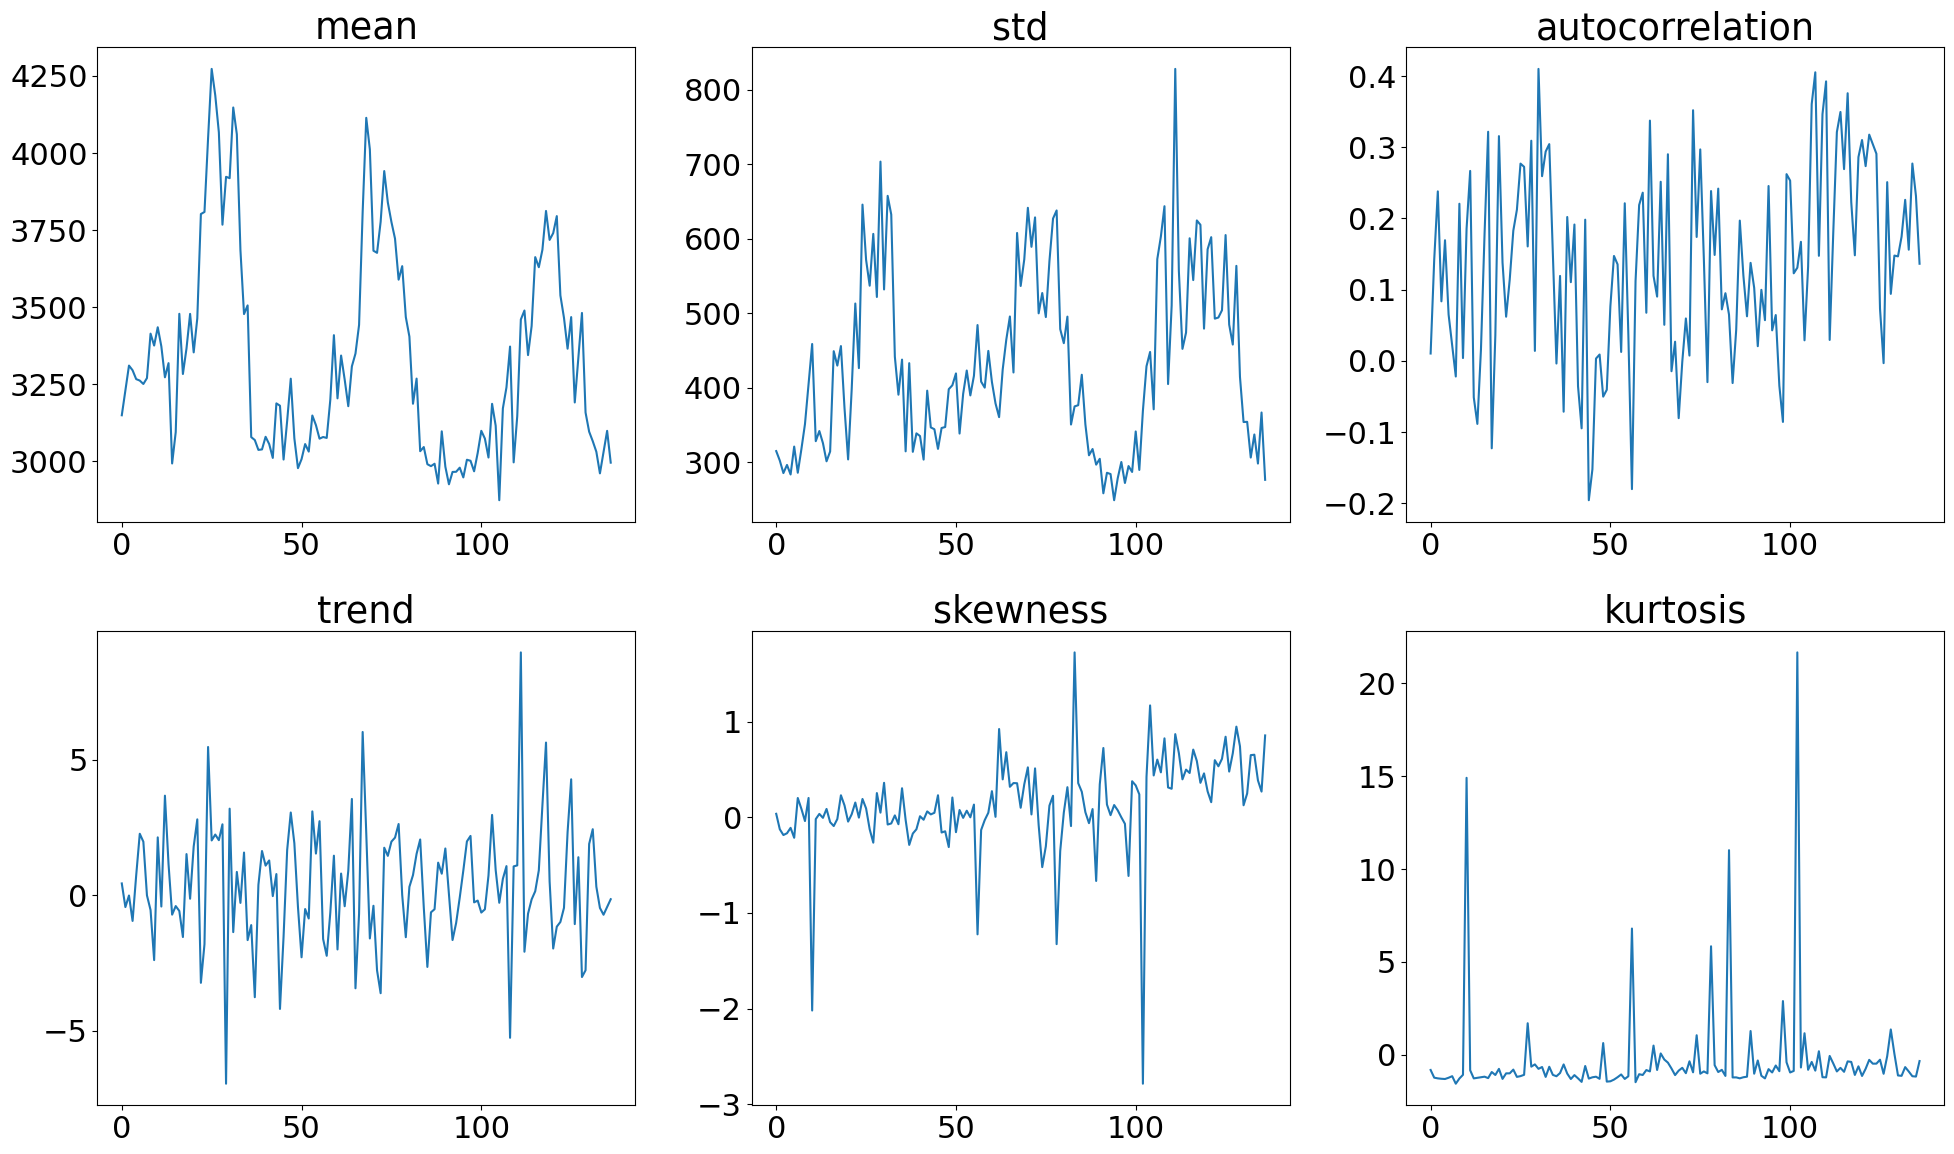

,mean,std,autocorrelation,trend,skewness,kurtosis
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,3335.883744,430.057559,0.136831,0.344303,0.137719,-0.305180
std,329.631294,117.679755,0.133316,2.176323,0.499528,2.734032
min,2874.291667,249.035466,-0.195771,-6.955447,-2.785053,-1.548989
25%,3069.369792,335.223607,0.035825,-0.717790,-0.040105,-1.171070
50%,3266.979167,408.269503,0.137980,0.145814,0.121482,-0.936277
75%,3481.515625,504.190734,0.241942,1.722913,0.359473,-0.550772
max,4272.901042,828.222961,0.410143,8.957778,1.722393,21.655305


In [266]:
def compute_statistics_change_over_time(
    df: pd.DataFrame, 
    target: str = "OT",
    slice_length: int = 96,
    plot=True
    ) -> pd.DataFrame:
    """
    For each (non-overlapping) slice of length slice_length, compute the statistics specified in quantities. 
    Store the final result as a new time series. 
    """

    lambdas = {
        "mean": lambda x: x.mean(),
        "std": lambda x: x.std(),
        "autocorrelation": lambda x: acf(x, nlags=slice_length//2)[-1],
        "trend": lambda x: linregress(range(len(x)), x).slope,
        "skewness": lambda x: x.skew(),
        "kurtosis": lambda x: x.kurtosis()
    }

    series = df.T.loc[target]
    statistics_df = defaultdict(list)

    for i in range(0, len(series), slice_length):
        slice = series[i:i+slice_length]
        for quantity, lambda_func in lambdas.items():
            statistics_df[quantity].append(lambda_func(slice))

    # If plot, plot the statistics in a 2x3 grid
    if plot:
        fig, axs = plt.subplots(2, 3)
        for i, quantity in enumerate(lambdas.keys()):
            axs[i//3, i%3].plot(statistics_df[quantity])
            axs[i//3, i%3].set_title(quantity)
        plt.tight_layout()
        plt.show()

    return pd.DataFrame(statistics_df)

ecl_statistics_df = compute_statistics_change_over_time(ecl_df, slice_length=96*2)
ecl_statistics_df.describe()

<h3> The mean changes in tact with the seasonality, as expected since we are just doing smoothing / moving average. More interesting is that the variance is seasonal as well, meaning more demand volatility when overall expected consumption is higher. </h2>

<h2> ETTh1 </h2>


In [267]:
ett_df = pd.read_csv(ETT_PATH / "ETTh1.csv")
ett_df["date"] = pd.to_datetime(ett_df["date"])
ett_df.set_index("date", inplace=True)
ett_df.sort_index(inplace=True)
ett_df.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


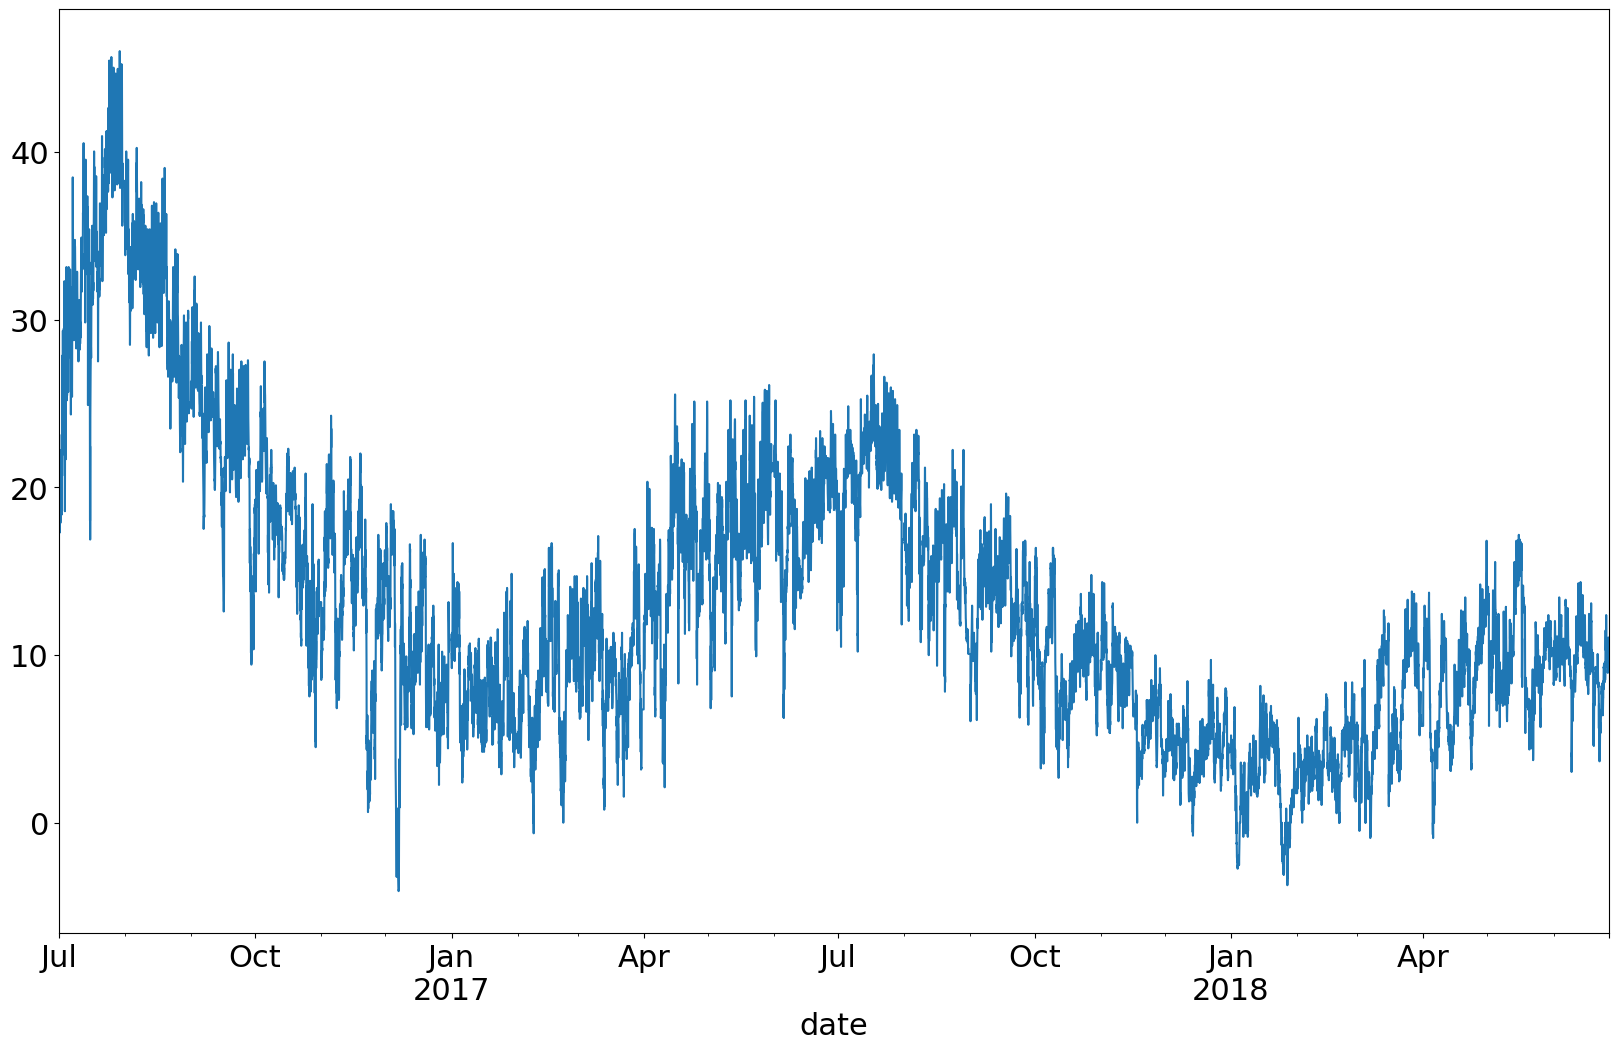

In [268]:
ett_df.T.loc["OT"].plot();

<h3> This one is more interesting, again with seasonality but with an overall downwards trend. </h3>

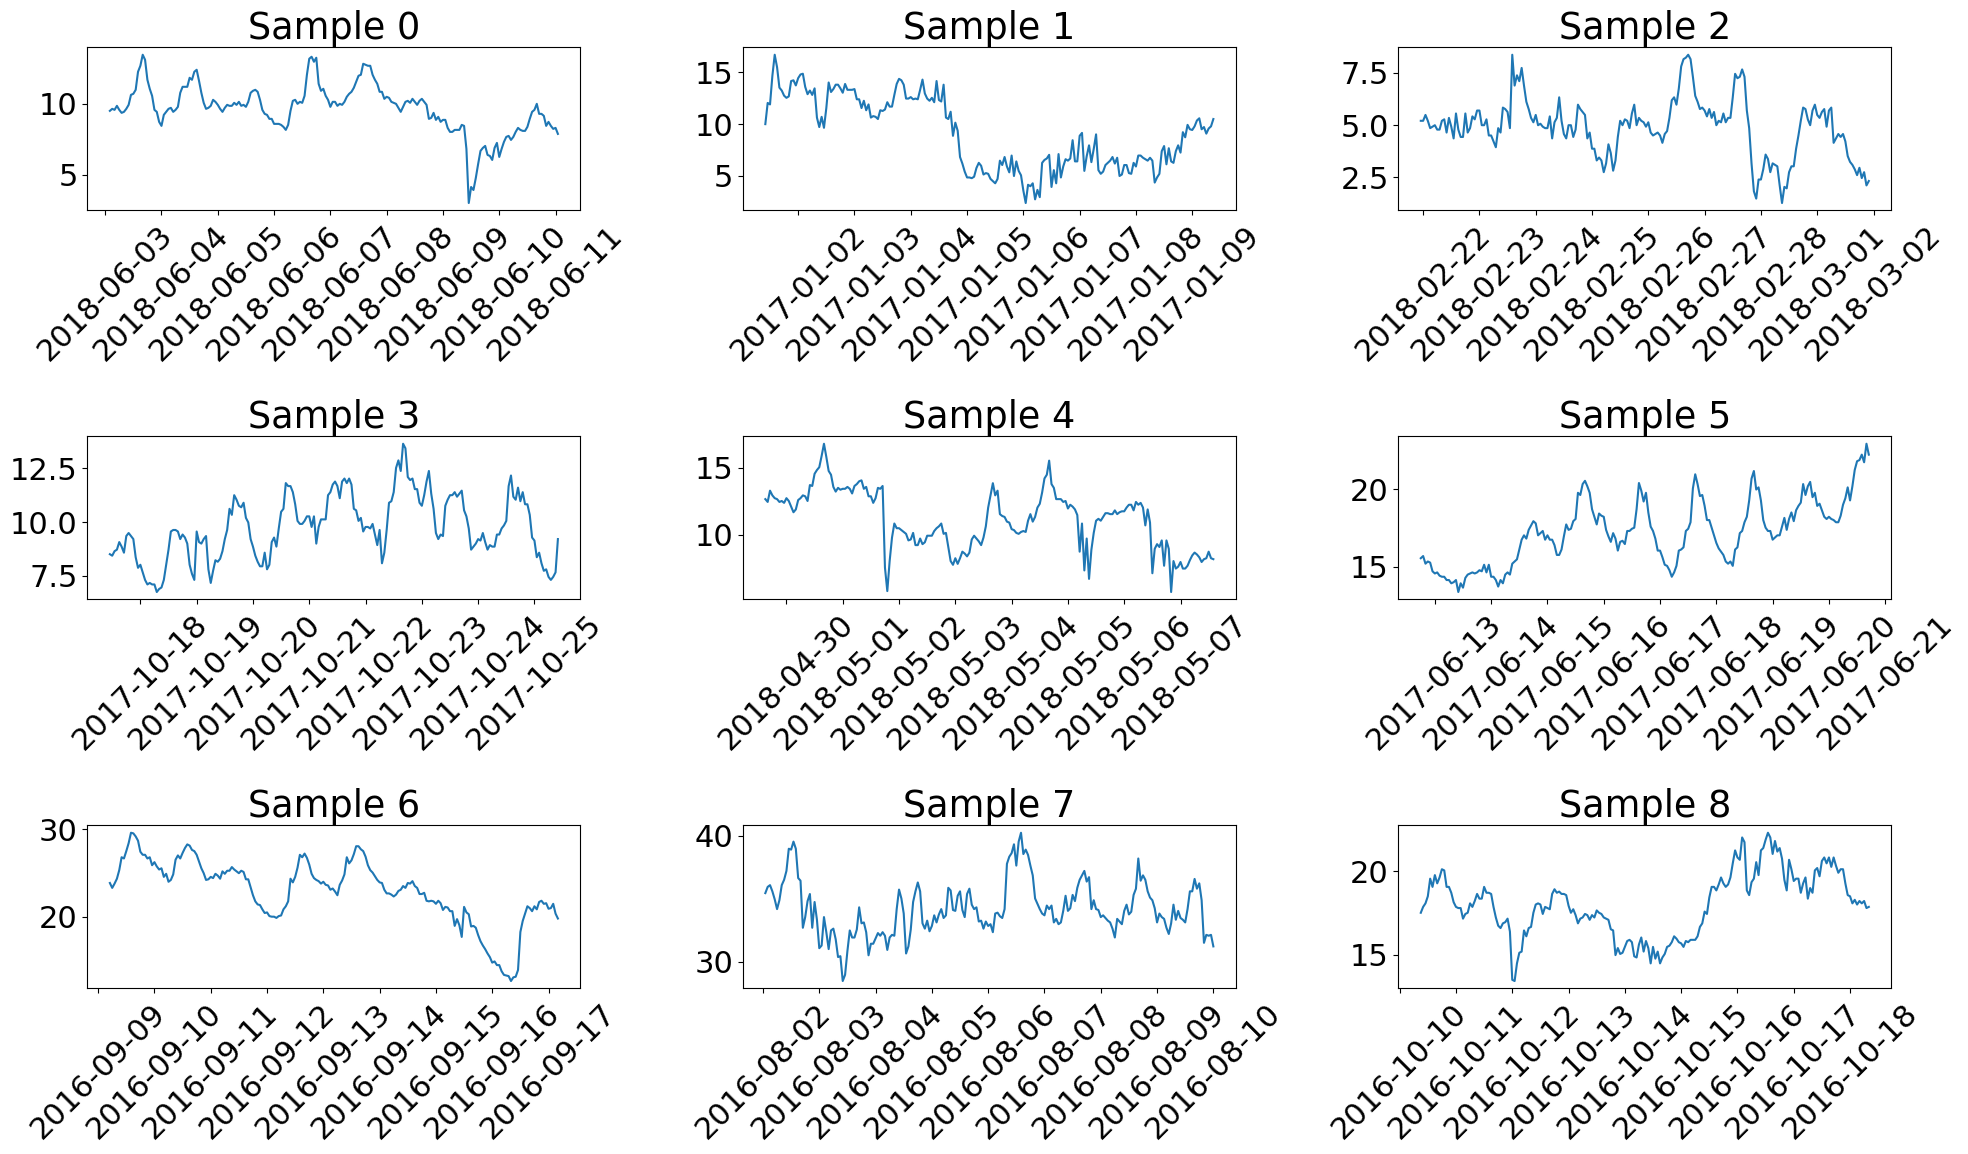

In [269]:
plot_samples(ett_df)

In [270]:
missing_value_summary(ett_df)

,Column,Missing_Count,Missing_Percentage


In [271]:
ett_outliers, ett_iqr_anomalies = iqr_anomaly_detect(ett_df)
ett_iqr_anomalies.loc["OT"]

0.02703788748564868

In [272]:
adf_test(ett_df)

ADF Statistic: -3.4879635775934608
p-value: 0.008301649485463814


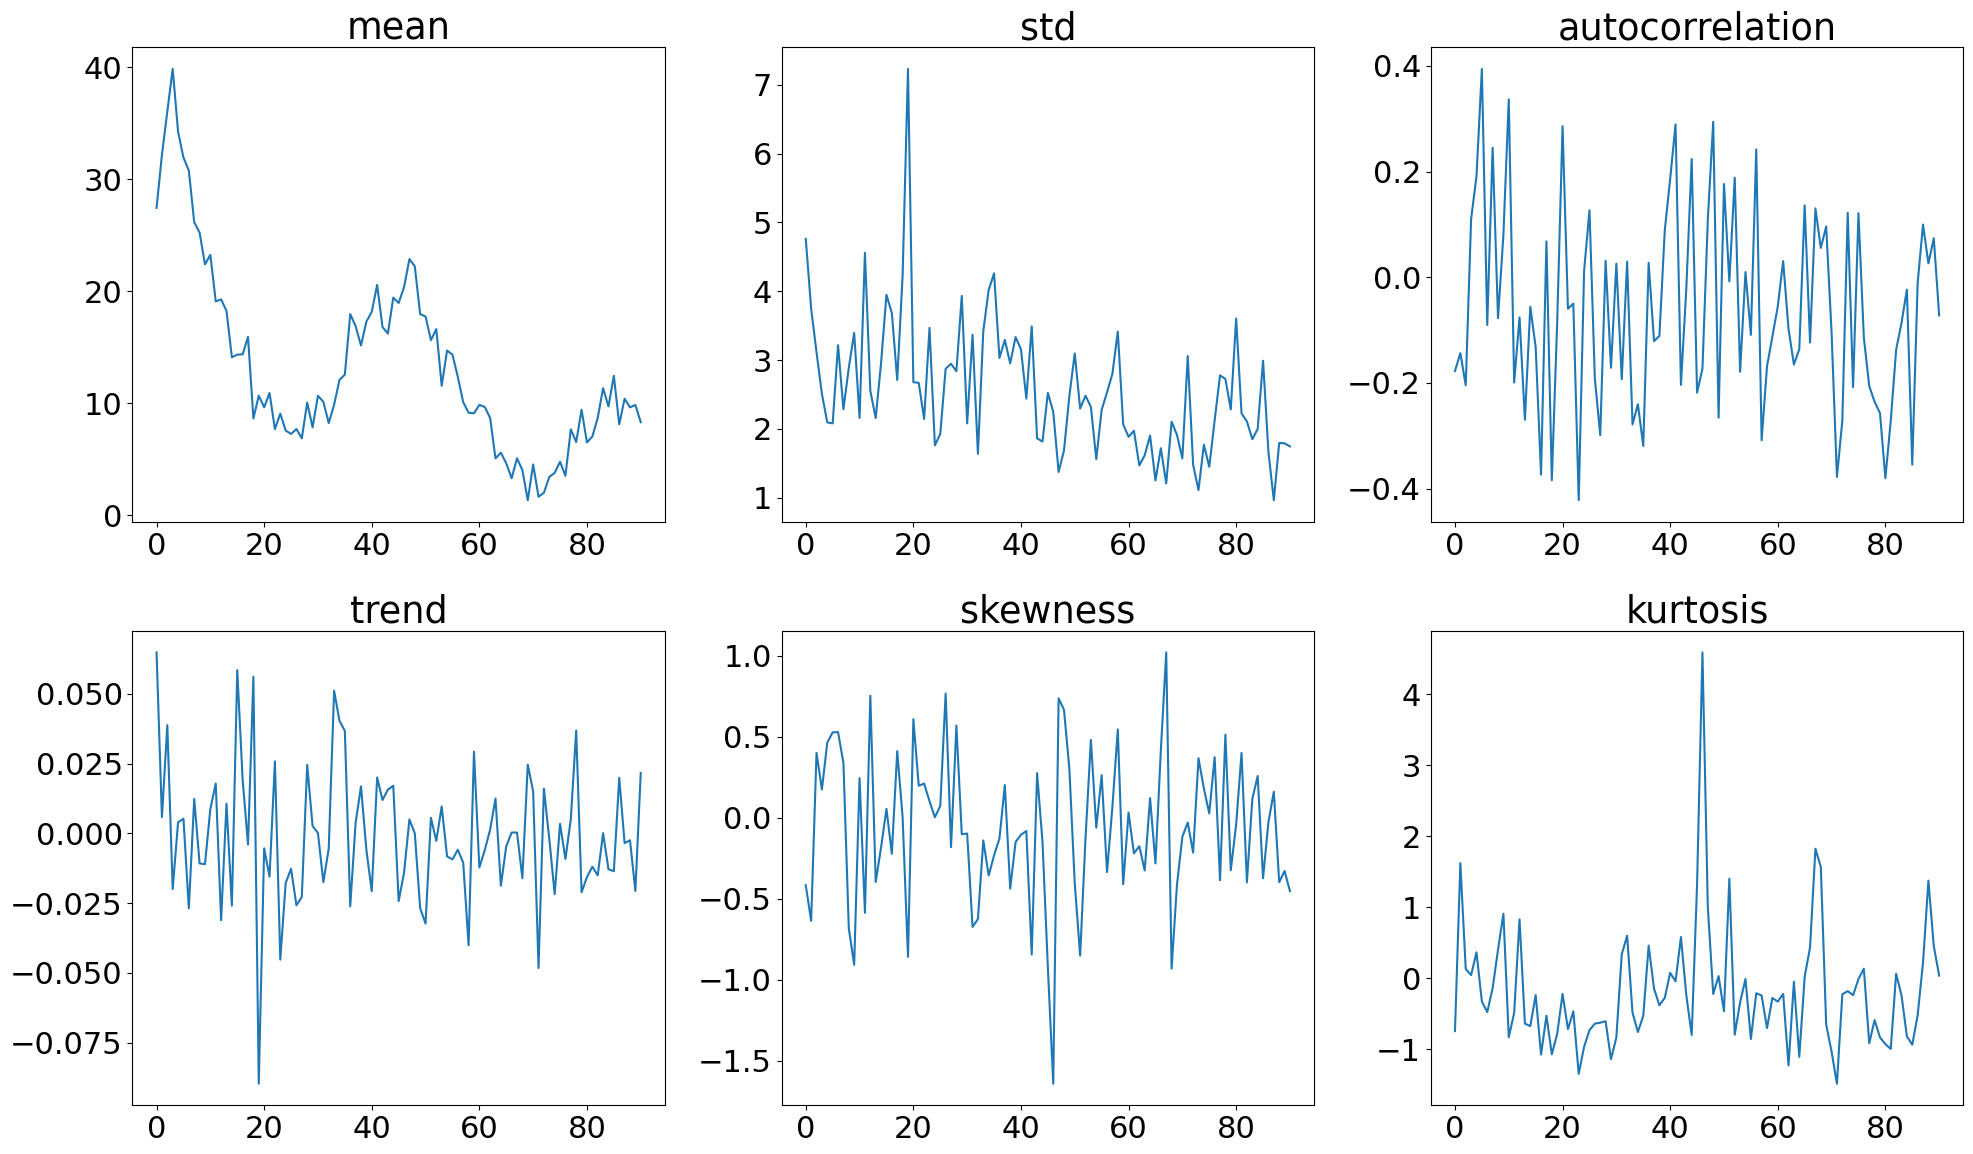

,mean,std,autocorrelation,trend,skewness,kurtosis
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,13.309741,2.559691,-0.060689,-0.001029,-0.060570,-0.183857
std,8.158115,0.962964,0.185609,0.024179,0.461729,0.858222
min,1.348354,0.963514,-0.422023,-0.089698,-1.642099,-1.485151
25%,7.776987,1.873730,-0.196105,-0.015598,-0.365669,-0.737448
50%,10.670026,2.317653,-0.085030,-0.002708,-0.082845,-0.276842
75%,17.850185,3.077335,0.076894,0.012440,0.259235,0.054754
max,39.843167,7.230382,0.394287,0.064866,1.019484,4.591824


In [273]:
ett_statistics_df = compute_statistics_change_over_time(ett_df, slice_length=96*2)
ett_statistics_df.describe()

<h2> Weather </h2>

In [274]:
weather_df = pd.read_csv(WEATHER_PATH / "weather.csv")
weather_df["date"] = pd.to_datetime(weather_df["date"])
weather_df.set_index("date", inplace=True)
weather_df.sort_index(inplace=True)
weather_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),OT
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,5.49,...,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45,428.1
2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,5.45,...,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51,428.0
2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,5.43,...,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60,427.6
2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,5.37,...,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70,430.0
2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,5.42,...,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81,432.2


In [275]:
weather_df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m�),PAR (�mol/m�/s),max. PAR (�mol/m�/s),Tlog (degC),OT
count,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,...,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000
mean,989.989233,10.818241,284.796938,5.409105,72.487133,14.487046,9.676828,4.810131,6.111159,9.782341,...,1.995935,3.632807,176.850276,0.011773,25.907469,131.331822,259.863438,308.601939,21.515206,417.798615
std,9.207149,7.468671,7.616995,5.956722,19.230260,7.632960,4.023504,5.539320,2.561536,4.082684,...,43.596931,2.462467,81.194840,0.123289,111.503420,215.735116,422.786515,569.956762,7.790620,321.570015
min,955.580000,-6.440000,266.190000,-13.810000,21.160000,3.770000,2.090000,0.000000,1.300000,2.090000,...,-9999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,6.900000,-9999.000000
25%,984.800000,4.590000,278.550000,0.777500,58.820000,8.480000,6.460000,1.170000,4.070000,6.530000,...,1.000000,1.770000,141.100000,0.000000,0.000000,0.000000,0.000000,0.000000,15.240000,415.500000
50%,990.920000,10.230000,284.320000,5.260000,75.400000,12.480000,8.890000,2.740000,5.610000,8.990000,...,1.770000,3.000000,195.500000,0.000000,0.000000,2.820000,9.670000,13.120000,20.440000,423.200000
75%,995.930000,16.180000,290.260000,9.700000,87.900000,18.420000,12.050000,6.440000,7.620000,12.200000,...,2.920000,4.850000,226.700000,0.000000,0.000000,182.900000,366.437500,434.260000,26.822500,437.100000
max,1020.070000,34.800000,309.130000,20.500000,100.000000,55.670000,24.160000,42.100000,15.400000,24.530000,...,13.770000,22.900000,360.000000,11.200000,600.000000,1115.290000,2131.760000,2498.940000,49.090000,524.200000


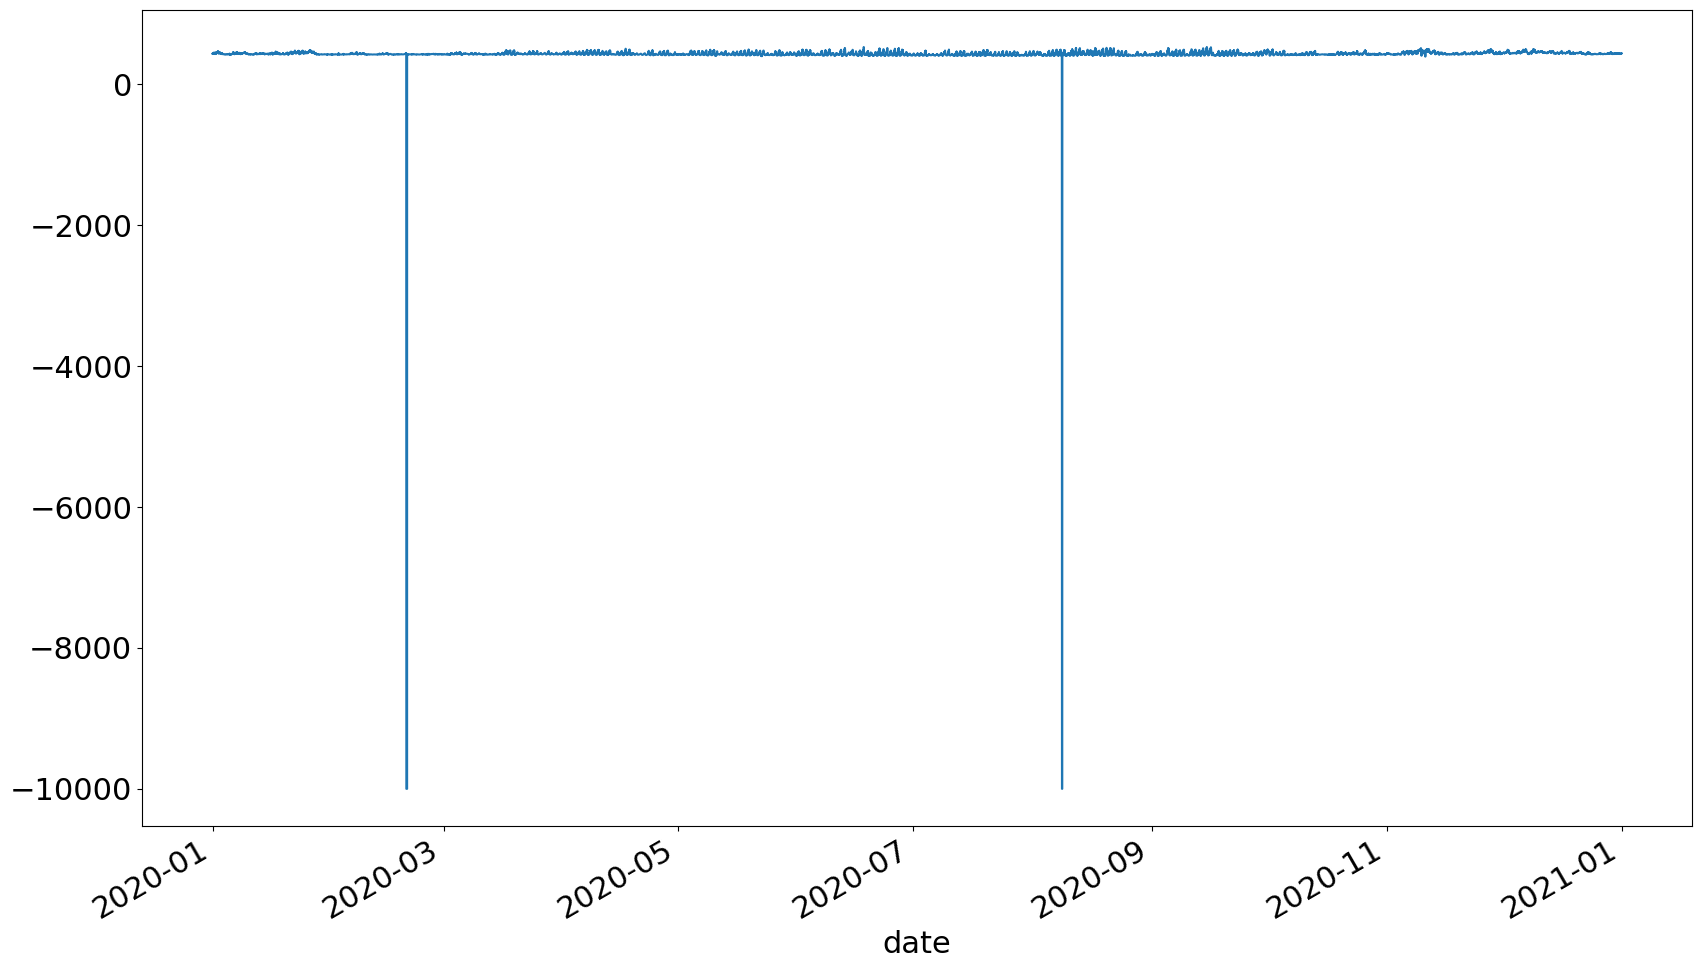

In [276]:
weather_df.T.loc["OT"].plot();

<h3> Two obvious outliers requiring removal (wonder why these are here, as this is commonly used benchmark data) </h3>

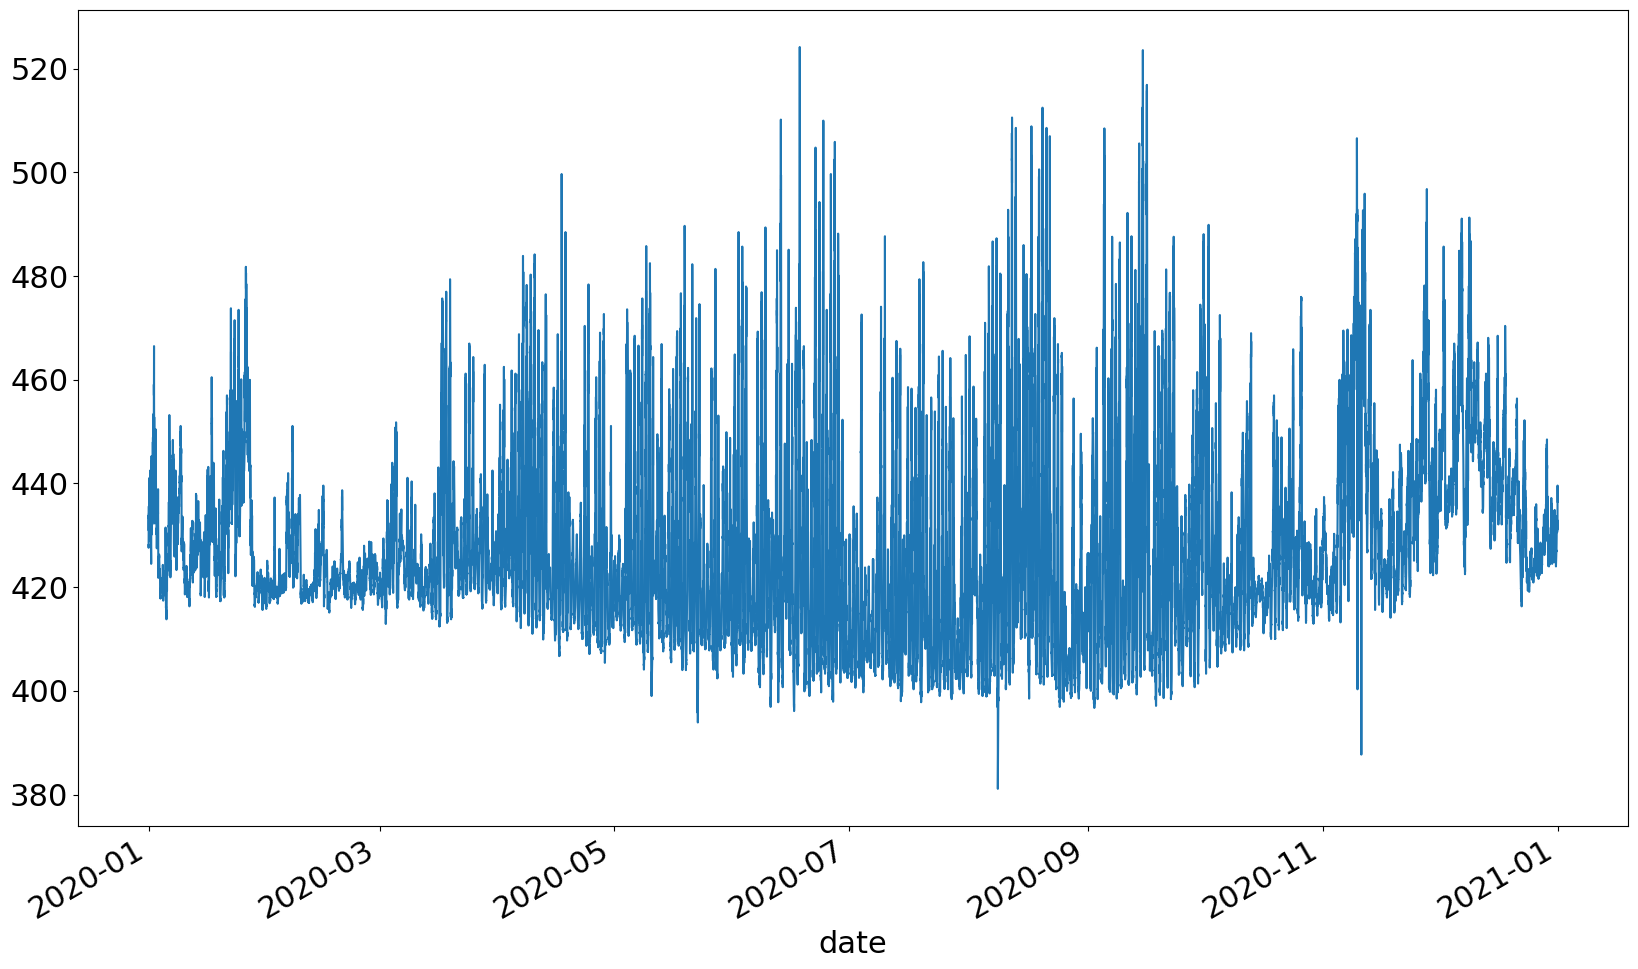

In [277]:
anomaly_mask = weather_df["OT"] < 350
weather_df.loc[anomaly_mask, "OT"] = np.nan
weather_df["OT"] = weather_df["OT"].interpolate()

weather_df.describe()
weather_df.T.loc["OT"].plot();

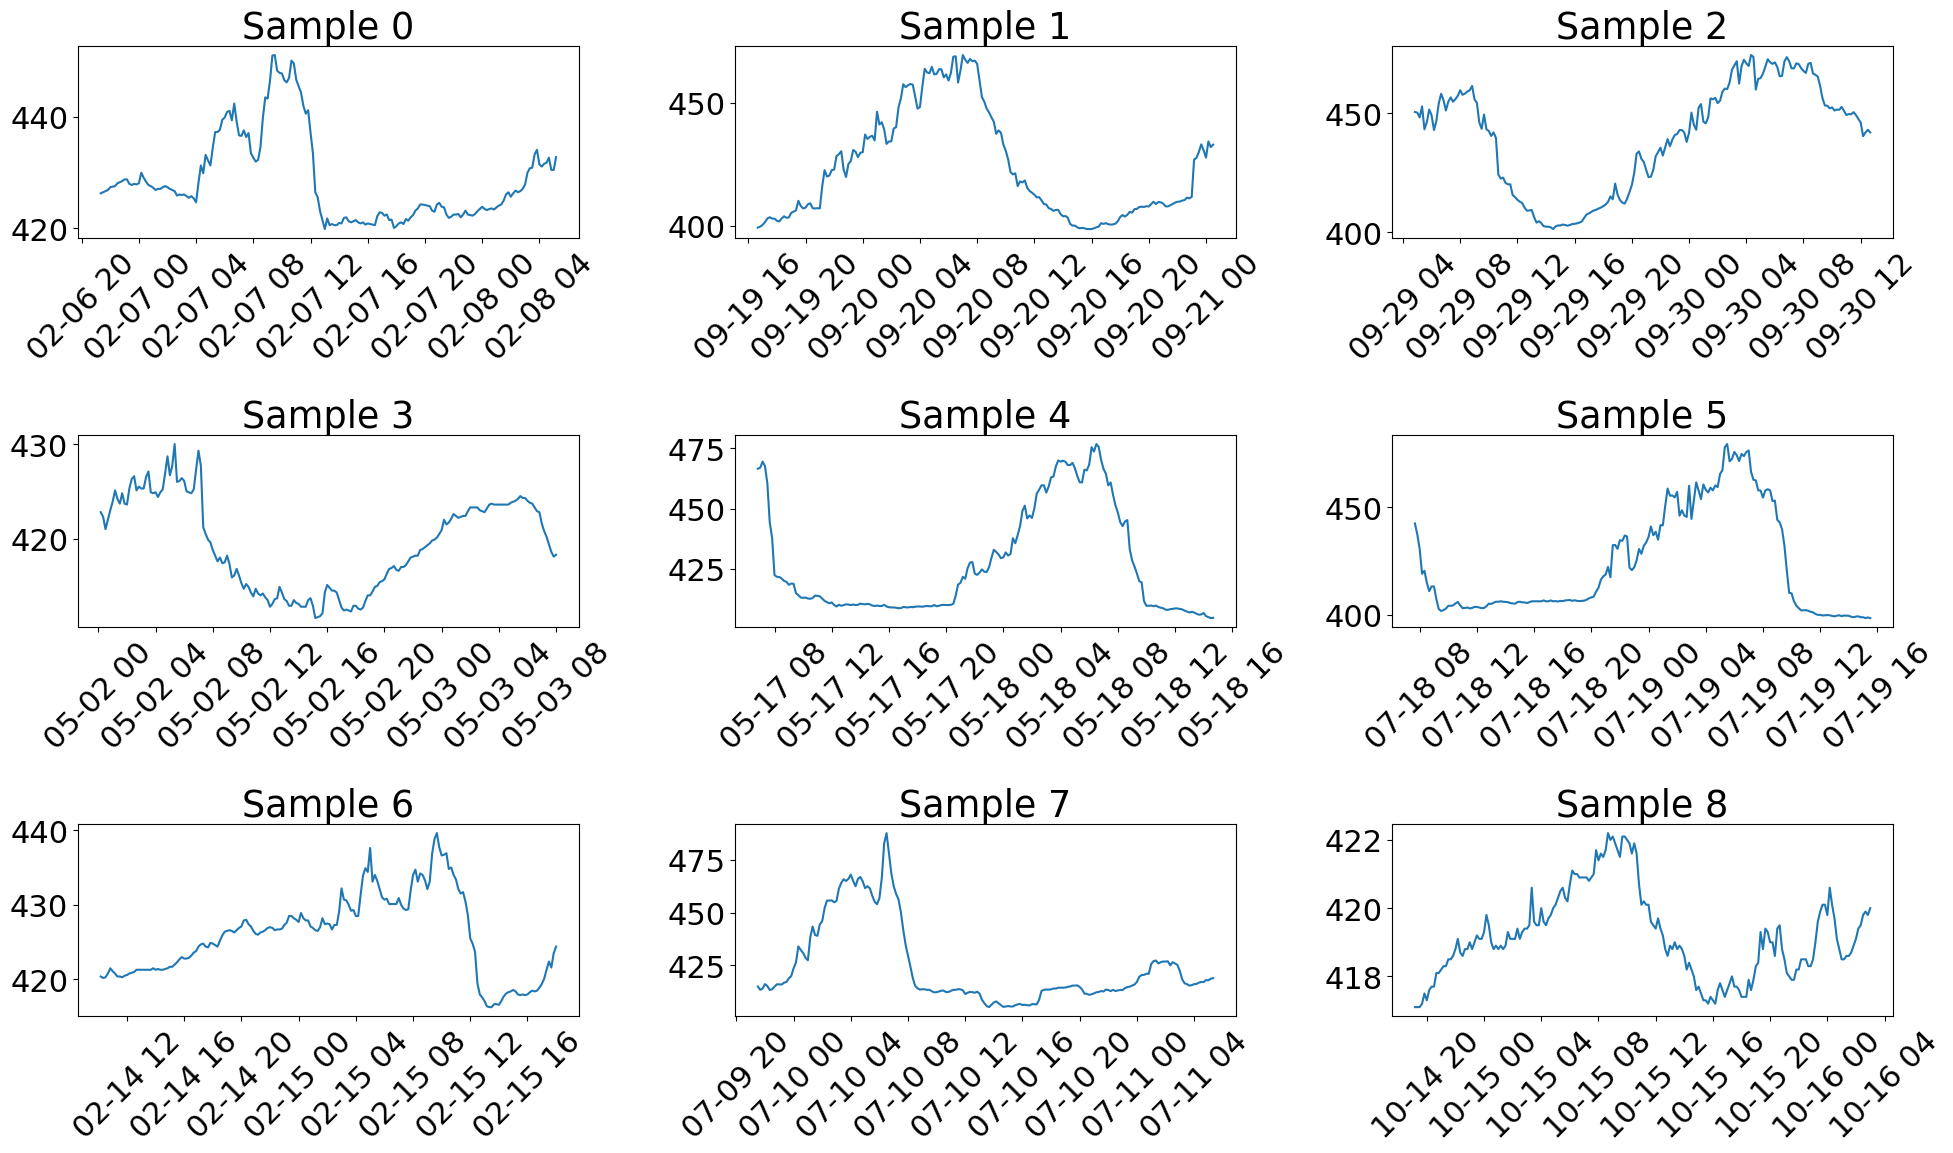

In [278]:
plot_samples(weather_df)

In [279]:
missing_value_summary(weather_df)

,Column,Missing_Count,Missing_Percentage


In [280]:
weather_outliers, weather_iqr_anomalies = iqr_anomaly_detect(weather_df)
weather_iqr_anomalies.loc["OT"]

0.03372172460907849

In [281]:
adf_test(weather_df)

ADF Statistic: -28.714087150186835
p-value: 0.0


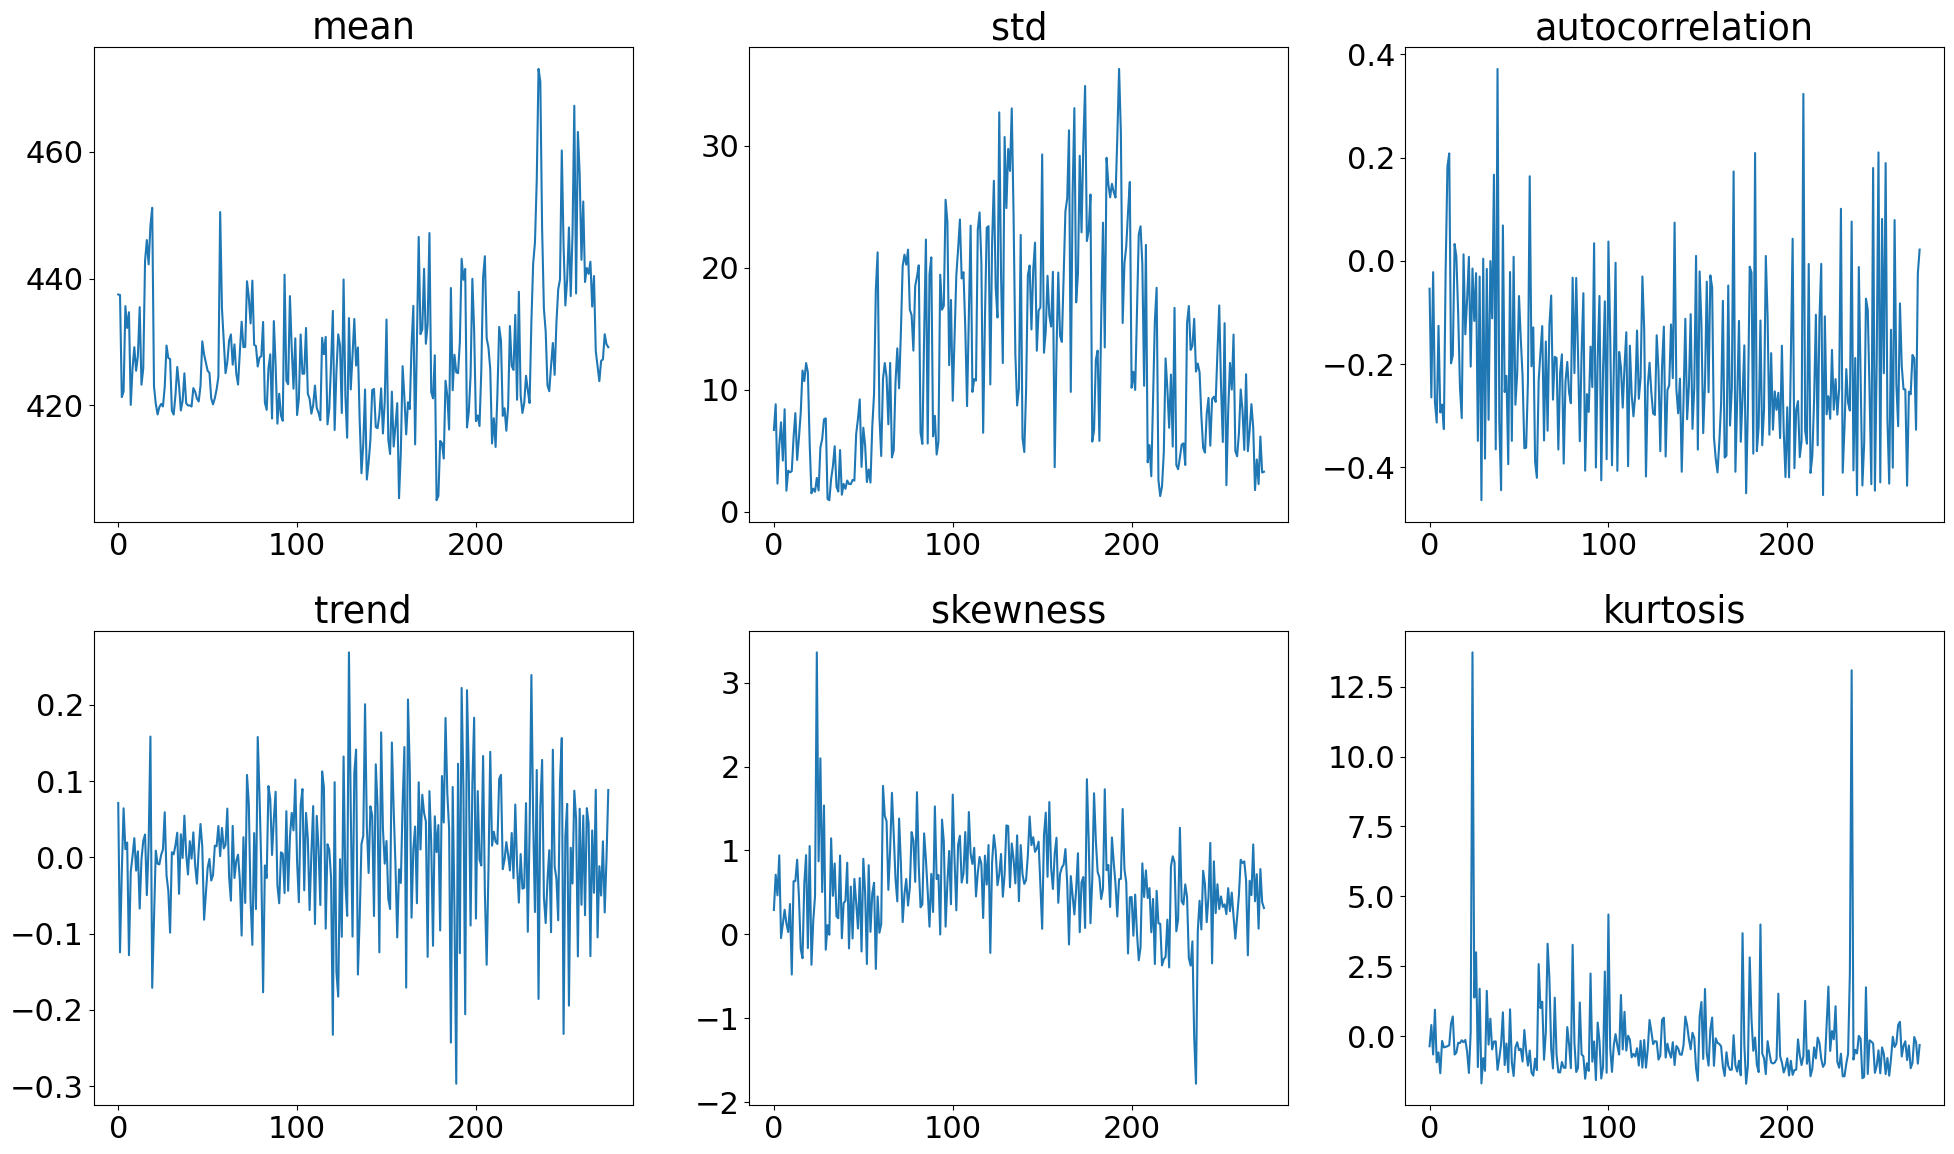

,mean,std,autocorrelation,trend,skewness,kurtosis
count,275.000000,275.000000,275.000000,275.000000,275.000000,275.000000
mean,427.685982,12.827298,-0.205680,0.005600,0.581672,-0.227531
std,10.768135,8.383969,0.159572,0.087077,0.545649,1.551273
min,405.032813,0.950255,-0.463615,-0.296618,-1.780314,-1.698038
25%,420.355469,5.604567,-0.325623,-0.046525,0.247057,-1.030151
50%,425.817708,11.247919,-0.237309,0.008815,0.601136,-0.512727
75%,432.868229,19.392692,-0.111004,0.059767,0.892448,-0.107274
max,473.083854,36.295429,0.372046,0.268517,3.360698,13.724574


In [282]:
weather_statistics_df = compute_statistics_change_over_time(
    weather_df, slice_length=96*2)
weather_statistics_df.describe()